In [1]:
# Setup Chunk
import numpy as np 
import pandas as pd 

import warnings 
warnings.simplefilter(action='ignore')

In [2]:
## DL packages
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

In [3]:
# Data Read
train_clinical = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
train_protein = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_proteins.csv")
train_peptide = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_peptides.csv")

In [4]:
train_clinical.shape

(2615, 8)

# Data Cleaning

## Repsonse Formatting

In [5]:
# Create Targets

patients = {}
for e in range(1,5):
    for m in [0,6,12,24]:
        train_clinical[f'updrs_{e}_plus_{m}_months'] = 0

for patient in train_clinical.patient_id.unique():
    temp = train_clinical[train_clinical.patient_id == patient]
    month_list = []
    month_windows = [0,6,12,24]
    for month in temp.visit_month.values:
        month_list.append([month, month + 6, month + 12, month + 24])
    for month in range(len(month_list)):
        for x in range(1,5):
            arr = temp[temp.visit_month.isin(month_list[month])][f'updrs_{x}'].fillna(0).to_list()
            if len(arr) == 4:
                for e, i in enumerate(arr):
                    m = month_list[month][0]
                    temp.loc[temp.visit_month == m,[f'updrs_{x}_plus_{month_windows[e]}_months']] = i
            else:
                temp = temp[~temp.visit_month.isin(month_list[month])]
    patients[patient] = temp

In [6]:
formatted_response = pd.concat(patients.values(), ignore_index=True).set_index('visit_id').iloc[:,7:]
formatted_response.head()
#formatted_response.isna().sum() # Check NAs

,updrs_1_plus_0_months,updrs_1_plus_6_months,updrs_1_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_0_months,updrs_2_plus_6_months,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,updrs_3_plus_12_months,updrs_3_plus_24_months,updrs_4_plus_0_months,updrs_4_plus_6_months,updrs_4_plus_12_months,updrs_4_plus_24_months
visit_id,,,,,,,,,,,,,,,,
55_0,10,8,10,16,6,10,10,9,15,34,41,49,0,0,0,0
55_6,8,10,7,14,10,10,13,13,34,41,38,49,0,0,0,0
55_12,10,7,16,17,10,13,9,18,41,38,49,51,0,0,0,0
55_18,7,16,14,12,13,9,13,20,38,49,49,41,0,0,0,0
55_24,16,14,17,17,9,13,18,16,49,49,51,52,0,0,0,0


## Cleaning Recipe

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import KNNImputer

# Data cleaning recipe. 

def recipe(clinical, protein, peptide, verbose = True, rep = True):
    if verbose: print('Preprocessing Steps')
    
    # Peptitde Abundance / Protein Expression 
    pep_over_pro = pd.merge(protein, peptide, 
                        on =['visit_id', 'visit_month', 'patient_id', 
                            'UniProt']) # joins the peptide and protein dataset

    # Creates feature in new column
    pep_over_pro['pep_per_pro'] = pep_over_pro['PeptideAbundance'] / pep_over_pro['NPX']
    
    if verbose: print('1. Add Peptide/Protein as new feature.')
    
    # Pivot the data to wide format. 
    pep_over_pro = pep_over_pro.drop(['patient_id', 'visit_month'], axis = 1).pivot(
    index = ['visit_id'], columns = ['Peptide'], values = ['pep_per_pro'])
    
    # Cleans erronous levels for smooth merge. 
    pep_over_pro.columns = pep_over_pro.columns.droplevel()
    pep_over_pro.reset_index()

    train = pd.merge(clinical, pep_over_pro, on = 'visit_id', 
                 how = 'left') # left join
    
    train = train.set_index('visit_id') # removes as feature, but in rowname for tracking
    
    # Drop med_status as a predictor (DOES NOT APPEAR IN TEST DATA)
    if rep:
        train = train.drop(['upd23b_clinical_state_on_medication'], axis = 1)
    
        if verbose: print('2. Dropped med_status as a predictor.')
        
    # Drop patient_id as a predictor 
    train = train.drop(['patient_id'], axis = 1)
    
    if verbose: print('3. Dropped patient_id as a predictor.')
    
    ## KNN Imputation ## 
    
    # Drops the response if it training data.
    if rep: 
        response = train[['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4']]
        train = train.drop(['updrs_1', 'updrs_2', 'updrs_3', 'updrs_4'], axis = 1)
    
    # Drops the categorical variables. 
    cats = train[['visit_month']]
    train = train.drop(['visit_month'], axis = 1)
    
    # Standardize numeric features. 
    scalar = StandardScaler()
    train = pd.DataFrame(scalar.fit_transform(train), columns = train.columns,
                        index = train.index)
    
    if verbose: print('4. Normalized numeric predictors.')
    
    # Add back in cats 
    train = train.join(cats)
    
    # Add unseens in testings as nan (need different imputer for much missing)
    #if not rep:
    #    test_add = np.setdiff1d(X.columns, 
    #                           train.columns).tolist()
    #    
    #    temp = pd.DataFrame(np.nan, 
    #                        columns = test_add, 
    #                        index = train.index)
    #    train = train.join(temp)
        
    # Apply KNN imputation 
    imputer = KNNImputer(n_neighbors = 5)
    train = pd.DataFrame(imputer.fit_transform(train), columns = train.columns, 
                        index = train.index)
    if rep: 
        response = pd.DataFrame(imputer.fit_transform(response), 
                                columns = response.columns, 
                                index = response.index)
    
    if verbose: print('5. KNN Imputation')
    
    # Add back in repsonse if training data. 
    if rep: 
        train = train.join(response)
    
    return train

In [8]:
# Test recipe 
train_clinical_fresh = pd.read_csv("/kaggle/input/amp-parkinsons-disease-progression-prediction/train_clinical_data.csv")
clean_test = recipe(train_clinical_fresh, train_protein, train_peptide, rep = True)
clean_test.head()

Preprocessing Steps
1. Add Peptide/Protein as new feature.
2. Dropped med_status as a predictor.
3. Dropped patient_id as a predictor.
4. Normalized numeric predictors.
5. KNN Imputation


,AADDTWEPFASGK,AAFGQGSGPIMLDEVQC(UniMod_4)TGTEASLADC(UniMod_4)K,AAFTEC(UniMod_4)C(UniMod_4)QAADK,AANEVSSADVK,AATGEC(UniMod_4)TATVGKR,AATVGSLAGQPLQER,AAVYHHFISDGVR,ADDKETC(UniMod_4)FAEEGK,ADDKETC(UniMod_4)FAEEGKK,ADDLGKGGNEESTKTGNAGSR,...,YVNKEIQNAVNGVK,YWGVASFLQK,YYC(UniMod_4)FQGNQFLR,YYTYLIMNK,YYWGGQYTWDMAK,visit_month,updrs_1,updrs_2,updrs_3,updrs_4
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,-0.097394,-0.611465,-0.482302,0.0,0.555718,0.388845,-0.055969,-1.188915,0.747080,0.138628,...,-0.235448,0.130248,-0.254317,-0.447802,-0.635128,0.0,10.0,6.0,15.0,2.8
55_3,-0.474096,-1.122953,-0.650454,0.0,-0.309951,0.157413,1.547536,0.143963,-0.820133,0.551960,...,0.933085,2.673593,1.413008,0.661591,0.246301,3.0,10.0,7.0,25.0,3.0
55_6,-0.236887,-0.887478,-0.043868,0.0,1.775712,0.125236,-0.082369,-1.187405,1.221974,0.103260,...,-0.578775,0.200504,-0.661579,-0.292764,-0.010148,6.0,8.0,10.0,34.0,3.4
55_9,0.249475,-1.713341,-0.572966,0.0,-0.329779,-0.103017,0.411495,-0.068773,-0.922437,0.856256,...,0.533902,0.592032,1.609423,-2.001862,-0.192085,9.0,8.0,9.0,30.0,0.0
55_12,-0.313668,-0.911808,-0.261373,0.0,0.110614,0.979999,-0.402378,-1.176289,0.379146,0.155990,...,0.226678,0.498383,-0.876679,0.069697,0.191490,12.0,10.0,10.0,41.0,0.0


## Autoencoder

In [9]:
# Extract the peptide/protein data to be reduced. 
clean_pep_pro = clean_test.iloc[:, :clean_test.shape[1] - 5]
#clean_pep_pro.head()

In [10]:
# Encoder Network
input_shape = [clean_pep_pro.shape[1]]
latent_shape = 10

encoder = tf.keras.Sequential()
encoder.add(Dense(500, input_shape = input_shape, activation = 'relu'))
encoder.add(Dropout(0.2))
encoder.add(Dense(250, activation = 'relu'))
encoder.add(Dropout(0.2))
encoder.add(Dense(latent_shape, activation = 'relu'))
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 500)               484500    
                                                                 
 dropout (Dropout)           (None, 500)               0         
                                                                 
 dense_1 (Dense)             (None, 250)               125250    
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                2510      
                                                                 
Total params: 612,260
Trainable params: 612,260
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Decoder Network
decoder = tf.keras.Sequential()
decoder.add(Dense(50, input_shape = encoder.output_shape, activation = 'relu'))
decoder.add(Dropout(0.2))
decoder.add(Dense(250, activation = 'relu'))
decoder.add(Dropout(0.2))
decoder.add(Dense(500, activation = 'relu'))
decoder.add(Dropout(0.2))
decoder.add(Dense(input_shape[0]))
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, None, 50)          550       
                                                                 
 dropout_2 (Dropout)         (None, None, 50)          0         
                                                                 
 dense_4 (Dense)             (None, None, 250)         12750     
                                                                 
 dropout_3 (Dropout)         (None, None, 250)         0         
                                                                 
 dense_5 (Dense)             (None, None, 500)         125500    
                                                                 
 dropout_4 (Dropout)         (None, None, 500)         0         
                                                                 
 dense_6 (Dense)             (None, None, 968)        

In [12]:
# Auto-encoder Network
visit = keras.Input(shape = input_shape)
latent_vector = encoder(visit)
output = decoder(latent_vector)

auto_encoder = keras.Model(inputs = visit, outputs = output)
auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 968)]             0         
                                                                 
 sequential (Sequential)     (None, 10)                612260    
                                                                 
 sequential_1 (Sequential)   (None, None, 968)         623768    
                                                                 
Total params: 1,236,028
Trainable params: 1,236,028
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Compile and auto-encoder model 
auto_encoder.compile('adam', loss = 'mse')

auto_encoder.fit(clean_pep_pro, clean_pep_pro, epochs = 100, 
                 validation_split = 0.2)

Epoch 1/100
66/66 [==============================] - 2s 15ms/step - loss: 0.5257 - val_loss: 0.5089
Epoch 2/100
66/66 [==============================] - 1s 12ms/step - loss: 0.4653 - val_loss: 0.4655
Epoch 3/100
66/66 [==============================] - 1s 12ms/step - loss: 0.4364 - val_loss: 0.4072
Epoch 4/100
66/66 [==============================] - 1s 12ms/step - loss: 0.3973 - val_loss: 0.3977
Epoch 5/100
66/66 [==============================] - 1s 12ms/step - loss: 0.3828 - val_loss: 0.3796
Epoch 6/100
66/66 [==============================] - 1s 12ms/step - loss: 0.3760 - val_loss: 0.3858
Epoch 7/100
66/66 [==============================] - 1s 12ms/step - loss: 0.3683 - val_loss: 0.3716
Epoch 8/100
66/66 [==============================] - 1s 12ms/step - loss: 0.3574 - val_loss: 0.3588
Epoch 9/100
66/66 [==============================] - 1s 12ms/step - loss: 0.3524 - val_loss: 0.3532
Epoch 10/100
66/66 [==============================] - 1s 12ms/step - loss: 0.3413 - val_loss: 0.3462

In [14]:
clean_encoded = encoder.predict(clean_pep_pro)
clean_encoded = pd.DataFrame(clean_encoded, 
                             index = clean_pep_pro.index)
clean_encoded

82/82 [==============================] - 0s 2ms/step


,0,1,2,3,4,5,6,7,8,9
visit_id,,,,,,,,,,
55_0,0.0,0.0,22.000591,0.0,21.826263,0.0,0.000000,16.530260,10.680049,0.0
55_3,0.0,0.0,0.000000,0.0,0.000000,0.0,1.565229,0.000000,0.000000,0.0
55_6,0.0,0.0,23.513136,0.0,23.417006,0.0,0.000000,17.678373,11.336211,0.0
55_9,0.0,0.0,0.000000,0.0,0.000000,0.0,10.328477,0.000000,0.000000,0.0
55_12,0.0,0.0,16.494810,0.0,14.715164,0.0,0.000000,10.299711,10.330498,0.0
...,...,...,...,...,...,...,...,...,...,...
65043_48,0.0,0.0,13.001646,0.0,16.277672,0.0,0.000000,9.165310,7.309073,0.0
65043_54,0.0,0.0,0.000000,0.0,0.000000,0.0,6.271467,12.787474,0.000000,0.0
65043_60,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0


In [15]:
train_features = clean_encoded.join(clean_test['visit_month'])
train_features.head()

,0,1,2,3,4,5,6,7,8,9,visit_month
visit_id,,,,,,,,,,,
55_0,0.0,0.0,22.000591,0.0,21.826263,0.0,0.000000,16.530260,10.680049,0.0,0.0
55_3,0.0,0.0,0.000000,0.0,0.000000,0.0,1.565229,0.000000,0.000000,0.0,3.0
55_6,0.0,0.0,23.513136,0.0,23.417006,0.0,0.000000,17.678373,11.336211,0.0,6.0
55_9,0.0,0.0,0.000000,0.0,0.000000,0.0,10.328477,0.000000,0.000000,0.0,9.0
55_12,0.0,0.0,16.494810,0.0,14.715164,0.0,0.000000,10.299711,10.330498,0.0,12.0


In [16]:
train_response = formatted_response
train_response

,updrs_1_plus_0_months,updrs_1_plus_6_months,updrs_1_plus_12_months,updrs_1_plus_24_months,updrs_2_plus_0_months,updrs_2_plus_6_months,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,updrs_3_plus_12_months,updrs_3_plus_24_months,updrs_4_plus_0_months,updrs_4_plus_6_months,updrs_4_plus_12_months,updrs_4_plus_24_months
visit_id,,,,,,,,,,,,,,,,
55_0,10,8,10,16,6,10,10,9,15,34,41,49,0,0,0,0
55_6,8,10,7,14,10,10,13,13,34,41,38,49,0,0,0,0
55_12,10,7,16,17,10,13,9,18,41,38,49,51,0,0,0,0
55_18,7,16,14,12,13,9,13,20,38,49,49,41,0,0,0,0
55_24,16,14,17,17,9,13,18,16,49,49,51,52,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65043_12,4,6,4,2,7,7,8,7,14,13,0,5,0,0,0,0
65043_18,6,4,3,9,7,8,4,10,13,0,4,15,0,0,0,0
65043_24,4,3,2,7,8,4,7,6,0,4,5,13,0,0,0,0


In [17]:
# Join into one training set
train = train_features.merge(
    train_response, left_index = True, right_index = True, 
    how = "right")
train

,0,1,2,3,4,5,6,7,8,9,...,updrs_2_plus_12_months,updrs_2_plus_24_months,updrs_3_plus_0_months,updrs_3_plus_6_months,updrs_3_plus_12_months,updrs_3_plus_24_months,updrs_4_plus_0_months,updrs_4_plus_6_months,updrs_4_plus_12_months,updrs_4_plus_24_months
visit_id,,,,,,,,,,,,,,,,,,,,,
55_0,0.0,0.0,22.000591,0.0,21.826263,0.000000,0.000000,16.530260,10.680049,0.000000,...,10,9,15,34,41,49,0,0,0,0
55_6,0.0,0.0,23.513136,0.0,23.417006,0.000000,0.000000,17.678373,11.336211,0.000000,...,13,13,34,41,38,49,0,0,0,0
55_12,0.0,0.0,16.494810,0.0,14.715164,0.000000,0.000000,10.299711,10.330498,0.000000,...,9,18,41,38,49,51,0,0,0,0
55_18,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,7.755474,5.442881,0.000000,...,13,20,38,49,49,41,0,0,0,0
55_24,0.0,0.0,3.543486,0.0,0.000000,5.200885,0.000000,0.000000,0.000000,0.000000,...,18,16,49,49,51,52,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65043_12,0.0,0.0,15.871954,0.0,21.297300,0.000000,0.000000,11.561789,9.674005,2.305862,...,8,7,14,13,0,5,0,0,0,0
65043_18,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,7.755474,5.442881,0.000000,...,4,10,13,0,4,15,0,0,0,0
65043_24,0.0,0.0,14.641208,0.0,12.529390,0.000000,0.000000,6.961373,15.328713,1.485610,...,7,6,0,4,5,13,0,0,0,0


# Model Training

In [18]:
# Training Setup
import keras_tuner

X = train.iloc[:, :latent_shape + 1]
y = train.iloc[:, train.shape[1] - 16:].astype('float')

input_shape = X.shape[1]
output_shape = y.shape[1]
#print(X)
#print(y)

In [19]:
# Setup custom loss function 
import tensorflow.keras.backend as K

def smape_loss(y_true, y_pred):
    epsilon = 0.1
    numer = K.abs(y_pred - y_true)
    denom = K.maximum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
    smape = numer / (denom/2)
    smape = tf.where(tf.math.is_nan(smape), tf.zeros_like(smape), smape)
    return smape

In [20]:
# Hypermodel Building Function 
def build_model(hp):
    model = keras.Sequential()
    # Input Layer
    model.add(keras.Input(shape = input_shape))

    # Tune the number of hidden layers
    for i in range(hp.Int("num_layers", min_value = 1, max_value = 5, step = 1)):
        model.add(
            # Tune the number of nodes in each layer
            layers.Dense(
                units = hp.Int(f"units{i}", min_value = 10, max_value = 30, step = 10), 
                # Tune activation function between layers
                activation = "relu")
        )
        # Dropout layer after each hidden layer to discourage overfitting
        model.add(
            layers.Dropout(
                rate = hp.Float("Dropout", min_value = 0, max_value = 0.5, step = 0.1)
            )
        )
            
    # Output Layer
    model.add(layers.Dense(output_shape))

    # Learning rate schedule with decay. 
    learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries = [500], values = [0.01, 0.001])

    # Model Compiler
    model.compile(
        loss = smape_loss, 
        optimizer = keras.optimizers.Adam(learning_rate = learning_rate_fn)
    )

    return model 

build_model(keras_tuner.HyperParameters())

In [21]:
# Hyperband Tunner
tuner = keras_tuner.Hyperband(
    hypermodel = build_model, 
    objective = "val_loss", 
    max_epochs = 100, 
    overwrite = True,
    seed = 123
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': 'linear'}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 30, 'step': 10, 'sampling': 'linear'}
Dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}


In [22]:
# Apply Model Tunner
#tuner.search(X, y, validation_split = 0.1)

In [23]:
# Final Model defined based on manuel stop to Hyperband Tuning
model_final = tf.keras.Sequential()
model_final.add(keras.Input(shape = input_shape))
model_final.add(Dense(20, activation = 'relu'))
model_final.add(Dense(20, activation = 'relu'))
model_final.add(Dense(20, activation = 'relu'))
model_final.add(Dense(10, activation = 'relu'))
model_final.add(Dense(30, activation = 'relu'))
model_final.add(Dense(output_shape))
model_final.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 20)                240       
                                                                 
 dense_12 (Dense)            (None, 20)                420       
                                                                 
 dense_13 (Dense)            (None, 20)                420       
                                                                 
 dense_14 (Dense)            (None, 10)                210       
                                                                 
 dense_15 (Dense)            (None, 30)                330       
                                                                 
 dense_16 (Dense)            (None, 16)                496       
                                                                 
Total params: 2,116
Trainable params: 2,116
Non-traina

In [24]:
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries = [500], values = [0.01, 0.001])

model_final.compile(keras.optimizers.Adam(learning_rate = learning_rate_fn), 
              loss = smape_loss)

Epoch 1/300
27/27 [==============================] - 1s 7ms/step - loss: 1.2979 - val_loss: 1.0451
Epoch 2/300
27/27 [==============================] - 0s 3ms/step - loss: 0.9786 - val_loss: 0.9486
Epoch 3/300
27/27 [==============================] - 0s 2ms/step - loss: 0.9162 - val_loss: 0.8790
Epoch 4/300
27/27 [==============================] - 0s 3ms/step - loss: 0.8875 - val_loss: 0.8745
Epoch 5/300
27/27 [==============================] - 0s 2ms/step - loss: 0.8774 - val_loss: 0.8804
Epoch 6/300
27/27 [==============================] - 0s 2ms/step - loss: 0.8754 - val_loss: 0.8818
Epoch 7/300
27/27 [==============================] - 0s 2ms/step - loss: 0.8708 - val_loss: 0.8651
Epoch 8/300
27/27 [==============================] - 0s 2ms/step - loss: 0.8674 - val_loss: 0.8761
Epoch 9/300
27/27 [==============================] - 0s 2ms/step - loss: 0.8649 - val_loss: 0.8841
Epoch 10/300
27/27 [==============================] - 0s 2ms/step - loss: 0.8665 - val_loss: 0.8582
Epoch 11/

<AxesSubplot: >

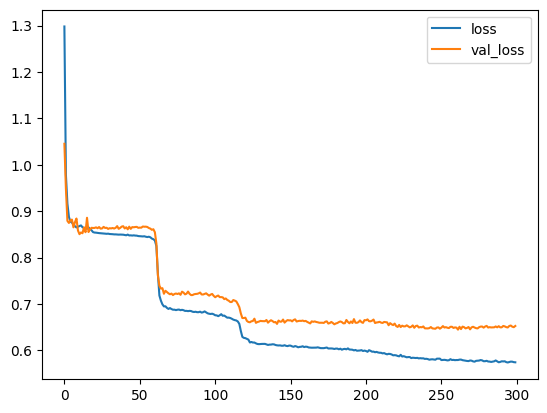

In [25]:
from keras.utils.vis_utils import plot_model
history = model_final.fit(
    X,
    y,
    epochs = 300,
    validation_split = 0.1
)

pd.DataFrame(history.history).plot()

# Predictions

In [26]:
def prepare_features(clinical, protein, peptides):
    
    # Match input format.
    clinical = clinical[['patient_id', 'visit_month', 'visit_id']]
    protein = protein.drop('group_key', axis = 1, errors = 'ignore')
    peptides = peptides.drop('group_key', axis = 1, errors = 'ignore')
    
    # Apply recipe. 
    clean = recipe(clinical, protein, peptides, rep = False)
    
    # Drop duplicate rows.
    clean = clean[~clean.index.duplicated(keep='first')]
    
    # Add features not seen during testing as 0.
    test_add = np.setdiff1d(clean_test.columns, 
                            clean.columns).tolist()
        
    temp = pd.DataFrame(0, 
                        columns = test_add, 
                        index = clean.index)
    clean = clean.join(temp)
    
    # Drop any features not seen during training.
    train_drops = np.setdiff1d(clean.columns, 
                               clean_test.columns).tolist()
    clean = clean.drop(train_drops, axis = 1)
    
    # Apply encoder
    clean_pep_pro = clean.iloc[:, :clean.shape[1] - 5]
    clean_pep_pro = encoder.predict(clean_pep_pro)
    clean_encoded = pd.DataFrame(clean_pep_pro)
    clean_encoded = clean_encoded.set_index(clean.index)
    
    clean = clean_encoded.join(clean['visit_month'])

    return clean

In [27]:
# Test prepare function 
#test_prep = prepare_features(train_clinical, train_protein, train_peptide)
#test_prep.head()

In [28]:
def get_predictions(features, model):
    pred_submission = np.around(np.abs(model.predict(features)),0)
    pred_submission = pd.DataFrame(pred_submission, index = features.index, columns = y.columns)
    return pred_submission

In [29]:
# Prediction Test
#test_pred = get_predictions(test_prep, model_final)
#print(formatted_response)
#print(test_pred)

In [30]:
def format_predictions(predictions, sample_submission):
    """Format predictions for submission"""
    pred_submission = pd.DataFrame(predictions.stack())

    # Map predictions to sample_submission
    pred_submission.index = pred_submission.index.map('_'.join)
    pred_submission.columns = ['rating']
    sample_submission.rating = sample_submission.prediction_id.map(pred_submission.rating)
    
    return sample_submission

In [31]:
import sys
sys.path.append('/kaggle/input/amp-parkinsons-disease-progression-prediction')

In [32]:
import amp_pd_peptide_310
env = amp_pd_peptide_310.make_env()   # initialize the environment
amp_pd_peptide_310.make_env.func_dict['__called__'] = False
iter_test = env.iter_test()    # an iterator which loops over the test files

In [33]:
for (test, test_peptides, test_proteins, sample_submission) in iter_test:
    sub_features = prepare_features(test, test_proteins, test_peptides)
    sub_predictions = get_predictions(sub_features, model_final)
    submission = format_predictions(sub_predictions, sample_submission)

    env.predict(submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
Preprocessing Steps
1. Add Peptide/Protein as new feature.
3. Dropped patient_id as a predictor.
4. Normalized numeric predictors.
5. KNN Imputation
1/1 [==============================] - 0s 63ms/step
Preprocessing Steps
1. Add Peptide/Protein as new feature.
3. Dropped patient_id as a predictor.
4. Normalized numeric predictors.
5. KNN Imputation
1/1 [==============================] - 0s 17ms/step


In [34]:
pd.read_csv('/kaggle/working/submission.csv')

,prediction_id,rating
0,3342_0_updrs_1_plus_0_months,9.0
1,3342_0_updrs_1_plus_6_months,8.0
2,3342_0_updrs_1_plus_12_months,9.0
3,3342_0_updrs_1_plus_24_months,10.0
4,3342_0_updrs_2_plus_0_months,8.0
...,...,...
59,50423_6_updrs_3_plus_24_months,23.0
60,50423_6_updrs_4_plus_0_months,0.0
61,50423_6_updrs_4_plus_6_months,0.0
62,50423_6_updrs_4_plus_12_months,0.0
